In [1]:
import flwr as fl 
import pandas as pd
import os 
import pickle
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tasks as ts
import warnings
import argparse
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from typing import Dict

import matplotlib.pyplot as plt

from flwr.common import NDArrays



In [2]:
data_1 = pd.read_csv('../IID_df_1.csv')
data_2 = pd.read_csv('../IID_df_2.csv')

In [3]:
scaler = MinMaxScaler()
smote = SMOTE(random_state=422)


In [4]:
test = pd.read_csv('../test_glob.csv')

In [5]:
X_train, y_train = data_1.drop(columns=["Fraud"]), data_1["Fraud"]


X_train_scale = scaler.fit_transform(X_train)
X_train_, y_train_ = smote.fit_resample(X_train_scale, y_train)



X_test, y_test = test.drop(columns='Fraud'), test.Fraud 
X_test_scale = scaler.transform(X_test)

model = LogisticRegression(
max_iter=10
)

In [7]:
# model.fit(X_train_2, y_train_2)
# y_pred_proba = model.predict_proba(X_test_scale)[:, 1]
# y_pred = model.predict(X_test_scale)

# loss = log_loss(y_test, y_pred_proba)
# accuracy = accuracy_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred_proba)
# f1 = f1_score(y_test, y_pred)



In [8]:
# (loss, accuracy, roc_auc, f1)

In [6]:
X_train, X_test, y_train, y_test = X_train_, X_test_scale, y_train_, y_test

In [7]:


def plot_metrics(losses, ROC_AUC, ACCURACY, F1):
   
    rounds = list(range(1, len(losses) + 1))
    
    plt.figure(figsize=(12, 8))
  
    plt.subplot(2, 2, 1)
    plt.plot(rounds, losses, color='blue')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(2, 2, 2)
    plt.plot(rounds, ROC_AUC, color='green')
    plt.title("ROC AUC over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("ROC AUC")

    plt.subplot(2, 2, 3)
    plt.plot(rounds, ACCURACY, color='orange')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(2, 2, 4)
    plt.plot(rounds, F1, color='red')
    plt.title("F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")

    plt.tight_layout()
    plt.show()



In [14]:
class CustomClientDP(fl.client.NumPyClient):
  
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.losses = []
        self.ROC_AUCs = []
        self.ACCURACYs = []
        self.F1s = []

    def get_parameters(self, config):
         
        return ts.get_model_parameters(model)
    
    def fit(self, parameters, config):
        ts.set_model_parameters(model, parameters)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train, y_train)
    
        
        return ts.get_model_parameters(model), len(X_train), {}

    def evaluate(self, parameters, config):
        
        ts.set_model_parameters(model, parameters)
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
       
        loss = log_loss(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)

        print(f'accuracy: {accuracy}')
        print(f'ROC_AUC: {roc_auc}')
        print(f'f1_score: {f1}')

        
        self.losses.append(loss)
        self.ROC_AUCs.append(roc_auc)
        self.ACCURACYs.append(accuracy)
        self.F1s.append(f1)
        
        
        return loss, len(X_test), {"accuracy": accuracy, "roc_auc": roc_auc, "f1-score": f1}


if __name__ == "__main__":
    N_CLIENTS = 2

    model = LogisticRegression(
        max_iter=1,
        warm_start=True
    )

    ts.set_initial_parameters(model)
    
    
    client_dp = CustomClientDP(model, X_train, X_test, y_train, y_test)

    
    fl.client.start_client(
        server_address="127.0.0.1:8080",
        client=client_dp
    )


INFO :      
INFO :      Received: train message e5d53cfe-9cca-49f9-9539-c7a8883deb6d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message a4c7d0c3-443b-4eeb-9880-ce3c2cb642b0
INFO :      Sent reply


INFO :      
INFO :      Received: train message 6a2c81e1-e6d1-4891-bcc1-2562c6bcc8ad
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 338d2031-10a3-4b7e-8ce0-69812fbeb21e
INFO :      Sent reply
INFO :      
INFO :      Received: train message 52f6624e-5372-4393-972b-ef2b21acfc92
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 320d17f1-776b-4a98-9b13-5c691ae14df9
INFO :      Sent reply
INFO :      
INFO :      Received: train message 27e5c51f-f508-4cd7-9340-af7b69b79ead
INFO :      Sent reply
INFO :      


accuracy: 0.9393644617380026
ROC_AUC: 0.7621556473829201
f1_score: 0.050761421319796954
accuracy: 0.695201037613489
ROC_AUC: 0.760068487909397
f1_score: 0.21797004991680533
accuracy: 0.5716601815823605
ROC_AUC: 0.7579028925619835
f1_score: 0.18907305095150398


INFO :      Received: evaluate message 86cc272e-ef9e-4731-b6da-06e9a671337f
INFO :      Sent reply
INFO :      
INFO :      Received: train message 91386c83-33bd-4cef-8bec-ba707aeb99dc
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 76652016-22ca-4594-9668-40bb0a6074fe
INFO :      Sent reply
INFO :      
INFO :      Received: train message 89ef5a47-251e-4190-858c-d68c025fa476
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 6dda94cf-86e6-4469-ba71-1474bce57c69
INFO :      Sent reply
INFO :      
INFO :      Received: train message 0c91cf6a-2d3c-496e-91c4-6bc323041e71
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 2e332b1d-cfeb-4e9b-9dd1-027191ff5af0
INFO :      Sent reply
INFO :      
INFO :      Received: train message 95500731-55a0-4732-b039-c0bbfa3ea53c


accuracy: 0.6757457846952011
ROC_AUC: 0.7604051882460973
f1_score: 0.21011058451816747
accuracy: 0.5593385214007782
ROC_AUC: 0.7580846342209977
f1_score: 0.18573996405032953
accuracy: 0.6562905317769131
ROC_AUC: 0.7606060606060607
f1_score: 0.2042042042042042
accuracy: 0.7360570687418937
ROC_AUC: 0.7651629935720846
f1_score: 0.2173076923076923


INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message a9bd1d78-53d0-4ebf-a788-db924a5a42ea
INFO :      Sent reply
INFO :      
INFO :      Received: train message e345b649-426c-42c9-9d55-f47627a52f02
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message e384e5a5-d044-4428-8010-6e40d80863f2
INFO :      Sent reply
INFO :      
INFO :      Received: train message 4dab0b36-7d47-4d5c-bdfc-5e67b90e2ea0
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 50f5761b-4059-4646-ac64-abdd06836e5b
INFO :      Sent reply
INFO :      
INFO :      Received: train message 5c3ecaea-c9c8-4ade-a45f-9d1d976b72b4
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 4103489d-122f-40ec-82e2-e8e59b464e6e
INFO :      Sent reply
INFO :      


accuracy: 0.6462386511024644
ROC_AUC: 0.7641165442301806
f1_score: 0.20306793279766253
accuracy: 0.6449416342412452
ROC_AUC: 0.7636574074074074
f1_score: 0.2047930283224401
accuracy: 0.6601815823605707
ROC_AUC: 0.7640993265993266
f1_score: 0.2096530920060332
accuracy: 0.6439688715953308
ROC_AUC: 0.7637970615243342
f1_score: 0.20549927641099855


INFO :      Received: train message 2e5380eb-4289-4d95-88d7-ef7b14aaa889
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message e8004a81-8e80-4273-a7ca-53b61daee97c
INFO :      Sent reply
INFO :      
INFO :      Received: train message ccb7b5bf-ffe7-49ee-aec2-636a4487d8f5
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 43095270-e2d8-4ff2-99b6-d2ad32435c64
INFO :      Sent reply
INFO :      
INFO :      Received: train message df44d057-b785-4fab-8403-cba235c772b5
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 01c644a4-464d-46c5-9b03-de3a4e1b05cd
INFO :      Sent reply
INFO :      
INFO :      Received: train message 3c094ae8-c505-48a8-b31f-a1b65c723a7b
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 09a5155f-af63-4d2f-8f8b-1c7e4b6120fe
INFO :      Sent reply


accuracy: 0.6585603112840467
ROC_AUC: 0.7641605448423631
f1_score: 0.20886551465063863
accuracy: 0.6423476005188068
ROC_AUC: 0.7639156718702174
f1_score: 0.2059035277177826
accuracy: 0.6566147859922179
ROC_AUC: 0.7642542852770124
f1_score: 0.20792819745699326
accuracy: 0.6391050583657587
ROC_AUC: 0.7639214110805019
f1_score: 0.20556745182012848


INFO :      
INFO :      Received: train message 35841cc8-8ac1-41e5-8f4c-f40c5d8f7820
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 1f05dbeb-15b2-4628-9f6b-08c061310598
INFO :      Sent reply
INFO :      
INFO :      Received: train message 61c2afb4-1e39-43b5-9197-62e36bac0749
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 242770ad-8d3d-41ae-9feb-586e9bc9211f
INFO :      Sent reply
INFO :      
INFO :      Received: train message 48c880dc-9904-4dad-b6dc-c2feaf760321
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 57077260-69a9-4bd7-83eb-0c4fa1e8ccb1
INFO :      Sent reply
INFO :      
INFO :      Received: train message 1b76cde2-3947-4e7f-8559-21d936903897
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 0287033f-2ca9-4cc5-bb17-5b9580cc9c28
INFO :      Sent reply
INFO :      
INFO :      Received: train message df0eee01-4986-4df6-840f-4a33b8834056
INFO :      Sent reply


accuracy: 0.6549935149156939
ROC_AUC: 0.764330808080808
f1_score: 0.20715350223546944
accuracy: 0.6819066147859922
ROC_AUC: 0.7643250688705234
f1_score: 0.20695230396119643
accuracy: 0.6559662775616083
ROC_AUC: 0.7640381083562902
f1_score: 0.20761762509335324
accuracy: 0.6523994811932555
ROC_AUC: 0.7640993265993267
f1_score: 0.20827178729689808


INFO :      
INFO :      Received: evaluate message cb410ce5-5790-4446-adc2-b35c31431dd6
INFO :      Sent reply
INFO :      
INFO :      Received: train message 7177ec18-b78d-4b24-a158-6a99d2810984
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 0ecf9f44-476d-4713-a7e9-6eec3a32d3a6
INFO :      Sent reply
INFO :      
INFO :      Received: train message 8d72da1e-9158-46d7-a893-87d7bd004a38
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 43d04af3-5ea2-444b-ba4e-1f61b92eafb7
INFO :      Sent reply
INFO :      
INFO :      Received: train message dd3502a5-65d0-4fd8-af09-d1d7fe66ed78
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message be1d4df4-adb6-427e-9416-1a3183d150a1
INFO :      Sent reply
INFO :      
INFO :      Received: train message 40ef21bd-5e21-4b33-812b-334944eae033
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 4bd3e0cf-2cba-4d7b-8ba6-5a32ce905f46
INFO :      Sent reply


accuracy: 0.642023346303502
ROC_AUC: 0.7645852464034283
f1_score: 0.20689655172413793
accuracy: 0.6527237354085603
ROC_AUC: 0.7648951637588002
f1_score: 0.20842572062084258
accuracy: 0.6520752269779507
ROC_AUC: 0.7649755127027855
f1_score: 0.20811808118081182
accuracy: 0.6511024643320363
ROC_AUC: 0.7650195133149679
f1_score: 0.2088235294117647
accuracy: 0.648508430609598
ROC_AUC: 0.7650386440159167
f1_score: 0.20760233918128654


INFO :      
INFO :      Received: train message 81f97c35-9931-4d35-a70b-bde70dfc3fcb
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message a89eaef9-ac8a-473b-b9e5-4c95ca200f06
INFO :      Sent reply
INFO :      
INFO :      Received: train message f04919f9-6842-415c-b406-644ead8bef0b
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 87f20302-9a09-4070-a57b-d6a59fc36465
INFO :      Sent reply
INFO :      
INFO :      Received: train message 3d9e88fc-db1d-4689-ac4f-81e24245be48
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 7a5b857f-3b35-4800-af94-f623c3340839
INFO :      Sent reply
INFO :      
INFO :      Received: train message 028de993-56dc-4745-944b-b09a68032ac6
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 4fcdc257-26f6-4e6b-bbfc-07a5e6204537
INFO :      Sent reply
INFO :      
INFO :      Received: train message 7b7dfe34-bc98-4c62-acd2-aa2b33e861a7
INFO :      Sent reply


accuracy: 0.643644617380026
ROC_AUC: 0.7650883838383838
f1_score: 0.20535068691250905
accuracy: 0.6530479896238651
ROC_AUC: 0.7653332568105295
f1_score: 0.2062314540059347
accuracy: 0.6446173800259404
ROC_AUC: 0.7652242118151208
f1_score: 0.20579710144927535
accuracy: 0.6316472114137484
ROC_AUC: 0.7657636975818793
f1_score: 0.20336605890603085


INFO :      
INFO :      Received: evaluate message 52b0f5ef-3fa7-47c9-8cf6-3070982a0c30
INFO :      Sent reply
INFO :      
INFO :      Received: train message 49fdc996-061c-4824-80fc-57a4f8327213
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 17d7bef7-fa05-4e1a-b42f-39308194bfed
INFO :      Sent reply
INFO :      
INFO :      Received: train message 86f0faef-a6d3-4aef-9794-ff07bb94bf3d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d5f41780-3a86-44d5-ab4c-d3c3252f8558
INFO :      Sent reply
INFO :      
INFO :      Received: train message b0c9c691-d52f-4ef7-b72e-936fc94d2221
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message e018581b-de5e-4dce-8615-d9ed31580b2d
INFO :      Sent reply
INFO :      
INFO :      Received: train message cfdf3553-d036-4a6f-a626-e990016aed54
INFO :      Sent reply


accuracy: 0.6416990920881972
ROC_AUC: 0.7660123966942148
f1_score: 0.20674802584350324
accuracy: 0.6433203631647212
ROC_AUC: 0.7660525711662075
f1_score: 0.20634920634920634
accuracy: 0.6481841763942932
ROC_AUC: 0.7661998775635138
f1_score: 0.20512820512820512
accuracy: 0.6407263294422828
ROC_AUC: 0.7660812672176308
f1_score: 0.20630372492836677


INFO :      
INFO :      Received: evaluate message a5b46467-a8b4-4c9a-93b3-b04b82371368
INFO :      Sent reply
INFO :      
INFO :      Received: train message 1410f155-560d-48e2-82d6-287ca2b5ebe1
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message edeaaa7a-8796-4062-9a37-18e0a3b59f17
INFO :      Sent reply
INFO :      
INFO :      Received: train message 917e5abc-77e8-4e37-9443-098a59ab11b1
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 14c5a5db-4fcb-42b0-9cdf-ee951b0711d7
INFO :      Sent reply
INFO :      
INFO :      Received: train message cd154291-28ef-4b27-8dc5-27b42ff50315
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 20d2808f-5a51-4940-92d6-3b489a615b9f
INFO :      Sent reply
INFO :      
INFO :      Received: train message 67bc55fa-0b76-4dea-8746-3388a8bbb249
INFO :      Sent reply
INFO :      


accuracy: 0.6475356679636836
ROC_AUC: 0.7670492806856443
f1_score: 0.20482809070958302
accuracy: 0.6374837872892347
ROC_AUC: 0.7668637128864402
f1_score: 0.20483641536273114
accuracy: 0.6384565499351491
ROC_AUC: 0.7669670186715641
f1_score: 0.2052744119743407
accuracy: 0.6410505836575876
ROC_AUC: 0.767072237526783
f1_score: 0.2064516129032258


INFO :      Received: evaluate message 28ae3a9d-73ce-4ca8-9323-2696a4d341ac
INFO :      Sent reply
INFO :      
INFO :      Received: train message 6fd32a11-e078-4aa3-a2f1-f0645a4725c7
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message a2a4210c-d3a0-418b-ad30-e02007e45c54
INFO :      Sent reply
INFO :      
INFO :      Received: train message 5dbf2e67-dc99-4595-a8ac-d4f83220546b
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message ad1dc3a7-ddc1-48b8-ac61-ba8c0abc21d0
INFO :      Sent reply
INFO :      
INFO :      Received: train message 21f3ac16-46d3-40ae-8386-6cc138a7ba72
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 6b2004ca-1e7c-4e17-b4f8-f7707ba0b161
INFO :      Sent reply
INFO :      
INFO :      Received: train message c10beef3-12d0-4d7b-a698-a4a4153f8ef6
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 0b888fd6-455b-454a-8525-13b0c29e6660
INFO :      Sent reply
INFO :      
INFO

accuracy: 0.6498054474708171
ROC_AUC: 0.7672673706764617
f1_score: 0.20471281296023564
accuracy: 0.6404020752269779
ROC_AUC: 0.767156412610958
f1_score: 0.20615604867573373
accuracy: 0.6387808041504539
ROC_AUC: 0.7671717171717173
f1_score: 0.20542082738944364
accuracy: 0.6319714656290532
ROC_AUC: 0.7674223293541476
f1_score: 0.20350877192982456
accuracy: 0.6397535667963683
ROC_AUC: 0.7675658096112642
f1_score: 0.2047244094488189


INFO :      
INFO :      Received: evaluate message 0e2338a2-e75f-449d-bb46-66240651128a
INFO :      Sent reply
INFO :      
INFO :      Received: train message bcf8b9b8-235b-4b97-8c10-6fc91b8ababd
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d65574d1-53a2-4740-bb1a-9711e0c26345
INFO :      Sent reply
INFO :      
INFO :      Received: train message 01b4f491-ac9c-4e13-8c23-0a811d89f281
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d6d4eb7a-1a62-4ace-93d4-a94db7a93894
INFO :      Sent reply
INFO :      
INFO :      Received: train message b692182f-d309-4e76-b3d7-e2ef02ecf11e
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message e764f4b2-0926-4421-9f17-9e083a8c5569
INFO :      Sent reply
INFO :      
INFO :      Received: train message 7939a55e-2410-4e4e-b5dc-83799cf65cd4
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message bee5e10a-019d-43b6-b79a-be86e89d7414
INFO :      Sent reply
INFO

accuracy: 0.6413748378728924
ROC_AUC: 0.7676652892561984
f1_score: 0.20317002881844382
accuracy: 0.6352140077821011
ROC_AUC: 0.7674586776859504
f1_score: 0.20382165605095542
accuracy: 0.6410505836575876
ROC_AUC: 0.7676442454851546
f1_score: 0.20302375809935205
accuracy: 0.642023346303502
ROC_AUC: 0.7676251147842056
f1_score: 0.20346320346320346
accuracy: 0.6605058365758755
ROC_AUC: 0.766540404040404
f1_score: 0.20741862225586677


INFO :      
INFO :      Received: evaluate message 3a40f7cc-a93d-4b34-aacf-f84d9131f27f
INFO :      Sent reply
INFO :      
INFO :      Received: train message d36476c2-d905-4969-b40e-2d9be2e92b52
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 4cdcc734-e0fc-492d-9f68-7093f6cda5c5
INFO :      Sent reply
INFO :      
INFO :      Received: train message a8844357-830d-4135-8a0f-a7ba0264dbdc
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message f0a63a42-a8f8-427a-b809-c5932284f9f7
INFO :      Sent reply
INFO :      
INFO :      Received: train message 31f9492f-709f-4699-b7f1-dc9f5f872f79
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message ac4c2b05-bb0b-42a7-9fe2-02f395cc06e8
INFO :      Sent reply
INFO :      
INFO :      Received: reconnect message 215d0103-b290-4fb8-8d05-81ead300c1c6
INFO :      Disconnect and shut down


accuracy: 0.6504539559014267
ROC_AUC: 0.7664696204468932
f1_score: 0.20501474926253688
accuracy: 0.6446173800259404
ROC_AUC: 0.7665327517600246
f1_score: 0.20232896652110627
accuracy: 0.6569390402075227
ROC_AUC: 0.7668101469237834
f1_score: 0.20808383233532934
accuracy: 0.6455901426718548
ROC_AUC: 0.7667814508723599
f1_score: 0.20277169948942378


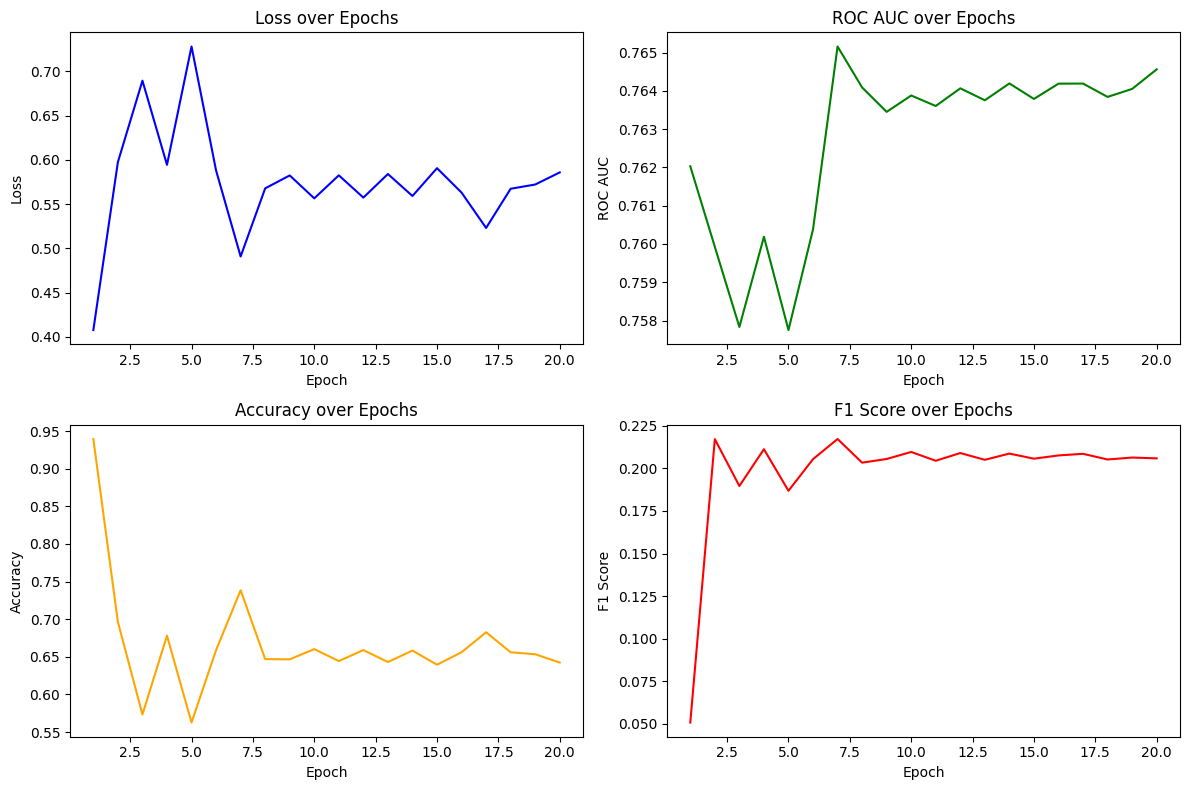

In [30]:
L, ROC_AUC, ACCURACY, F1 = client_dp.losses, client_dp.ROC_AUCs, client_dp.ACCURACYs, client_dp.F1s
plot_metrics(L, ROC_AUC, ACCURACY, F1)

In [10]:
class CustomClient_Paillier(fl.client.NumPyClient):

        
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.losses = []
        self.ROC_AUCs = []
        self.ACCURACYs = []
        self.F1s = []
    
        with open('../public_key.pkl', 'rb') as f:
            self.__public_key = pickle.load(f)

        with open('../private_key.pkl', 'rb') as f:
            self.__private_key = pickle.load(f)


    def get_parameters(self, config):

        print('================== INITIAL PARAMS ==================')
        params = ts.get_model_parameters(model)
        print(params)

        return params

    def fit(self, parameters, config):
        
        print('============================ PARAMS BEFORE  FIT===========================')
        
        # decrypted_params = [(self.__private_key.decrypt(value),) for param in parameters for value in param.flatten()]
        # dec_res = []
        # index = 0
        # for param in parameters:
        #        num_elements = param.size
        #        reshaped_array = np.array(decrypted_params[index:index + num_elements]).reshape(param.shape)
        #        dec_res.append(reshaped_array)
        #        index += num_elements
        # print(parameters)
        
        ts.set_model_parameters(model, parameters)
                
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train, y_train)
        print(f"Training finished for round {config['server_round']}")
        print('============================= PARAMETERS AFTER FIT ===============================')
        params_1 = ts.get_model_parameters(model)
        print(f'clear: {params_1}')

        encrypted_params = [(self.__public_key.encrypt(value),) for param in params_1 for value in param.flatten()]
        enc_result = []
        index = 0

        for param in params_1:
                num_elements = param.size
                reshaped_array = np.array(encrypted_params[index:index + num_elements]).reshape(param.shape)
                enc_result.append(reshaped_array)
                index += num_elements
            # encrypt parameters here


        print(f'Encrypted: {enc_result}')
        
        return enc_result, len(X_train), {}

    def evaluate(self, parameters, config):
        print('========================== evaluate PARAMS =============================================')
        # i got agg parameters for server, here i have to decrypt them
        print(parameters, parameters[0].size, parameters[1].size)
        decrypted_params = [(self.__private_key.decrypt(value),) for param in parameters for value in param.flatten()]
        dec_res = []
        index = 0
        for param in parameters:
               num_elements = param.size
               reshaped_array = np.array(decrypted_params[index:index + num_elements]).reshape(param.shape)
               dec_res.append(reshaped_array)
               index += num_elements
        print(f' Decrypted for EVAL {dec_res}')


        
        ts.set_model_parameters(model, dec_res)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        loss = log_loss(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)
        print(f'accuracy: {accuracy}')
        print(f'ROC_AUC: {roc_auc}')
        print(f'f1_score: {f1}')
        self.losses.append(loss)
        self.ROC_AUCs.append(roc_auc)
        self.ACCURACYs.append(accuracy)
        self.F1s.append(f1)

        
        return loss, len(X_test), {"accuracy": accuracy, "roc_auc": roc_auc, "f1-score": f1}

if __name__ == "__main__":


    client_paillier = CustomClient_Paillier(model, X_train, X_test, y_train, y_test)
    model = LogisticRegression(
        max_iter=1,
        warm_start=True
    )

    ts.set_initial_parameters(model)

    fl.client.start_client(
        server_address="127.0.0.1:8080",
        client=client_paillier
    )

INFO :      
INFO :      Received: train message 90eb9c0b-e9cb-4edd-90d8-3190484f2767


============================ PARAMS BEFORE  FIT===========================
Training finished for round 1
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-3.67152661e-02, -8.75604181e-02, -2.90514321e-02,
        -7.25983055e-02, -4.26906494e-02, -2.74191021e-02,
        -2.67323236e-02, -5.14038004e-02,  1.75825247e-01,
        -2.02401841e-02, -5.06665123e-02, -6.31777197e-01,
        -9.51778410e-02, -3.01756534e-01,  8.68778597e-02,
        -5.51477086e-02, -5.75119838e-02,  1.81104068e-02,
         2.46935377e-02, -1.89446278e-02, -4.21954231e-03,
        -1.73996087e-01, -5.29620824e-02, -5.01387830e-02,
        -1.55281095e-02, -3.37363466e-02, -1.09346006e-01,
        -1.34546277e-02, -2.41253103e-04, -8.47200051e-02,
        -6.09664163e-01,  0.00000000e+00,  5.09946752e-02]]), array([2.68379644e-16])]


INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000002C8BA6571F0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000002C8BA68D480>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 3d01f72c-f7a2-4d00-b3a5-35b15f10da4d


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000002C8BA68EDD0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000002C8BA68C4C0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 3f582562-6703-4c5f-b963-e45efdc72de0
ERROR :     Client raised an exception.
Traceback (most recent call last):
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\flwr\client\app.py", line 379, in _start_client_internal
    reply_message = client_app(message=message, context=context)
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\flwr\client\client_app.py", line 98, in __call__
    return self._call(message, context)
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\flwr\client\client_app.py", line 81, in ffn
    out_message = handle_legacy_message_from_msgtype(
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\flwr\client\message_handler\message_handler.py", line 130, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\

 Decrypted for EVAL [array([[-0.04035642, -0.06838285, -0.04901064, -0.08041477, -0.05967494,
         0.0137327 , -0.05450042, -0.0270502 ,  0.1934429 , -0.01912221,
        -0.06654014, -0.60300138, -0.08105414, -0.28374685,  0.08911177,
        -0.06062822, -0.00356938,  0.00323606,  0.0363628 , -0.00799729,
        -0.00237556, -0.21984822, -0.07152266, -0.0411051 , -0.00924902,
        -0.03192408, -0.15789523, -0.01266152, -0.00180927, -0.0951876 ,
        -0.60414156,  0.        ,  0.0384818 ]]), array([2.60270951e-16])]
accuracy: 0.9393644617380026
ROC_AUC: 0.7621556473829201
f1_score: 0.050761421319796954
============================ PARAMS BEFORE  FIT===========================


TypeError: float() argument must be a string or a real number, not 'EncryptedNumber'

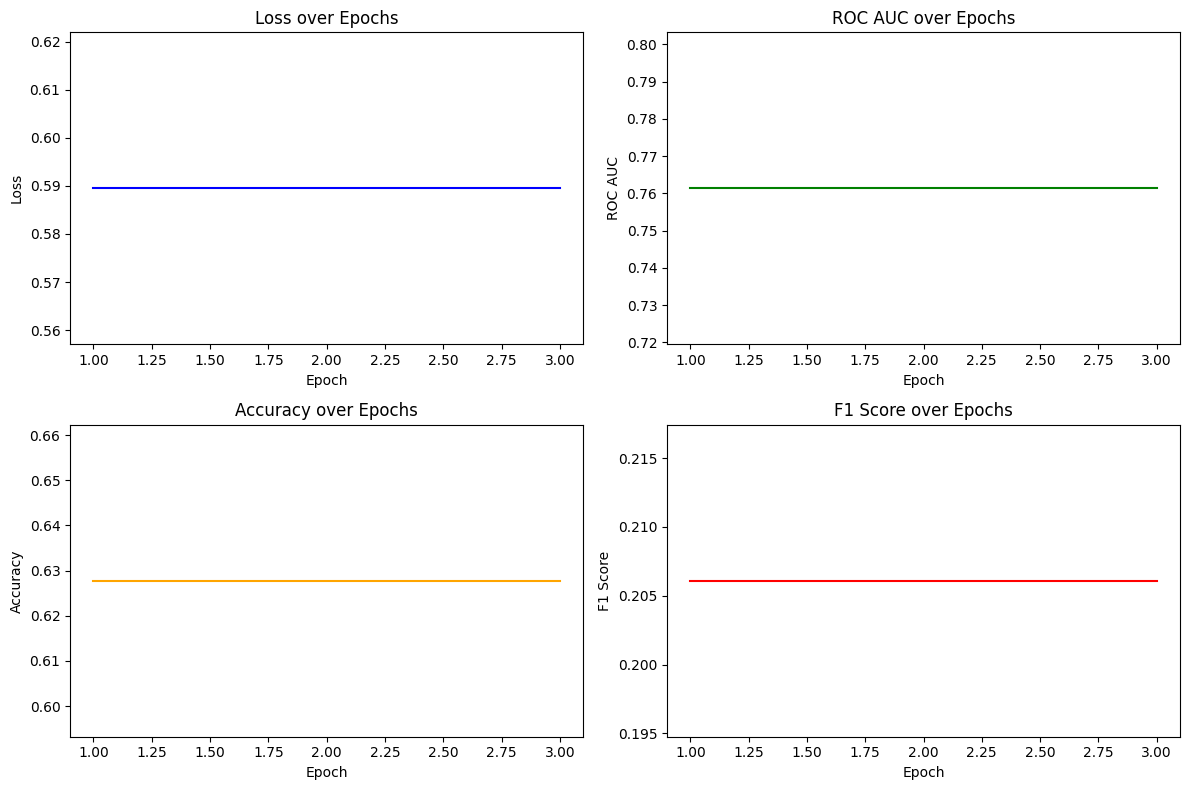

In [108]:
L, ROC_AUC, ACCURACY, F1 = client_paillier.losses, client_paillier.ROC_AUCs, client_paillier.ACCURACYs, client_paillier.F1s
plot_metrics(L, ROC_AUC, ACCURACY, F1)

In [12]:
ts.__dict__

{'__name__': 'tasks',
 '__doc__': None,
 '__package__': '',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x2191267fc10>,
 '__spec__': ModuleSpec(name='tasks', loader=<_frozen_importlib_external.SourceFileLoader object at 0x000002191267FC10>, origin='c:\\Users\\Астемир\\Desktop\\Flwr\\FedAvg\\tasks.py'),
 '__file__': 'c:\\Users\\Астемир\\Desktop\\Flwr\\FedAvg\\tasks.py',
 '__cached__': 'c:\\Users\\Астемир\\Desktop\\Flwr\\FedAvg\\__pycache__\\tasks.cpython-310.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
  '__package__': '',
  '__loader__': _frozen_importlib.BuiltinImporter,
  '__spec__': ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImporter'>, origin='built-in'),
  '__build_class__': <function __build_class__>,
  '__import__': <function __import__>,
  'abs': <function abs(x, /)>,
  'all': <function al

In [14]:
# class CustomClient(fl.client.NumPyClient):
    
#     def __init__(self):
        
#         super().__init__()
#         self.lOSS = []
#         self.ROC_AUC = []
#         self.ACCURACY = []
#         self.F1 = []



#     def fit(self, parameters, config):
#         ts.set_model_parameters(model, parameters)
#         print(f'STUDY ::: [LOCAL FIT]')
       
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             model.fit(X_train_2, y_train_2)
        
#         return ts.get_model_parameters(model), len(X_train_2), {}

#     def evaluate(self, parameters, config):
#         print(f'STUDY ::: [EVALUATE]')
#         ts.set_model_parameters(model, parameters)
        
#         y_pred_proba = model.predict_proba(X_test_scale)[:, 1]
#         y_pred = model.predict(X_test_scale)
        
#         loss = log_loss(y_test, y_pred_proba)
#         accuracy = accuracy_score(y_test, y_pred)
#         roc_auc = roc_auc_score(y_test, y_pred_proba)
#         f1 = f1_score(y_test, y_pred)

#         print(f'Accuracy: {accuracy}')
#         print(f'ROC_AUC: {roc_auc}')
#         print(f'F1_score: {f1}')

#         self.lOSS.append(loss)
#         self.ROC_AUC.append(roc_auc)
#         self.ACCURACY.append(accuracy)
#         self.F1.append(f1)
        
        
#         return loss, len(X_test_scale), {"accuracy": accuracy, "roc_auc": roc_auc, "f1-score": f1}


# if __name__ == "__main__":
    
#     N_CLIENTS = 2

#     model = LogisticRegression(
#         penalty='l2',
#         max_iter=10
#     )

#     ts.set_initial_parameters(model)
    
    
#     client = CustomClient()

    
#     fl.client.start_client(
#         server_address="127.0.0.1:8080",
#         client=client
#     )

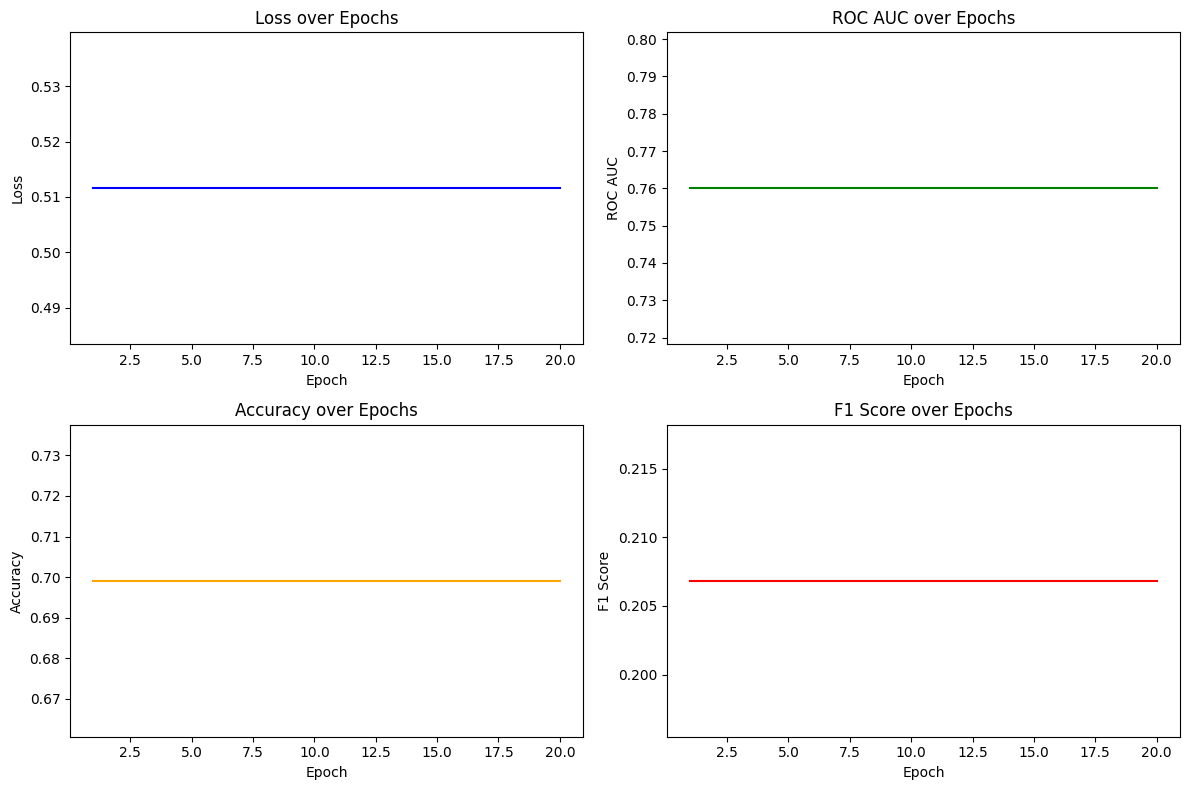

In [17]:
L, ROC_AUC, ACCURACY, F1 = client.lOSS, client.ROC_AUC, client.ACCURACY, client.F1
plot_metrics(L, ROC_AUC, ACCURACY, F1)